<a href="https://colab.research.google.com/github/Olesiewitch/Predictive_Analytics/blob/master/CausalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install causalml
import numpy as np
import pandas as pd

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain

from sklearn.model_selection import train_test_split

%matplotlib inline 


     |████████████████████████████████| 3.8MB 2.7MB/s 
     |████████████████████████████████| 276kB 30.1MB/s 
     |████████████████████████████████| 1.8MB 17.3MB/s 
  Created wheel for causalml: filename=causalml-0.7.1-cp36-cp36m-linux_x86_64.whl size=465768 sha256=afbfcdc3c2de378e5a5c30680633bbb18146d22a1e284f211deb7160318b4222
  Stored in directory: /root/.cache/pip/wheels/83/f7/ac/67b9c6acd9b6489256700811205d8aa731b55fe80a086d3e74
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394113 sha256=585f7cacb401af767ed30c32fc642c4b576a3f316fe5b21e41c8889490860638
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
dataurl='https://raw.githubusercontent.com/Olesiewitch/Predictive_Analytics/master/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv'
df = pd.read_csv(dataurl)
df.keys()

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend'],
      dtype='object')

In [3]:

# Rename columns 
df = df.rename(columns= {'segment' : 'Treatment'})

# Create dummy columns
dummy_cols = ['zip_code', 'history_segment', 'channel']
for col in dummy_cols:
  df = pd.get_dummies(df, columns=[col], prefix=col)

# Encode the 'Treatment' Column

treatment_encoder = {'No E-Mail': 'Control', 'Mens E-Mail': 'Treatment-Men', 'Womens E-Mail': 'Treatment-Women'}
df['Treatment'] = df['Treatment'].apply(lambda x: treatment_encoder[x])

df.head()

,recency,history,mens,womens,newbie,Treatment,visit,conversion,spend,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,Treatment-Women,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,6,329.08,1,1,1,Control,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,7,180.65,0,1,1,Treatment-Women,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,9,675.83,1,0,1,Treatment-Men,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,2,45.34,1,0,0,Treatment-Women,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,1


In [0]:
normalization_fields = ['recency', 'history']
df[normalization_fields] = (df[normalization_fields] - df[normalization_fields].mean()) / df[normalization_fields].std()

In [5]:
pd.crosstab(df['Treatment'],df['visit'], margins= True)

visit,0,1,All
Treatment,,,
Control,19044,2262,21306
Treatment-Men,17413,3894,21307
Treatment-Women,18149,3238,21387
All,54606,9394,64000


In [6]:
df.pivot_table(values=['visit', 'conversion','spend'],
               index = 'Treatment',
               aggfunc=[np.mean],
               margins = True)


mean                    
                conversion     spend     visit
Treatment                                     
Control           0.005726  0.652789  0.106167
Treatment-Men     0.012531  1.422617  0.182757
Treatment-Women   0.008837  1.077202  0.151400
All               0.009031  1.050908  0.146781

In [7]:
df_red = df.drop(columns=["conversion", "spend"])
df_red.head()
df_red.shape

(64000, 20)


## **Run the uplift random forest classifier**



In [0]:
# Split data to training and testing samples 
df_train, df_test = train_test_split(df_red, test_size = 0.3, random_state = 123)

In [0]:
uplift_model = UpliftRandomForestClassifier(control_name='Control')


In [24]:
x_names = list(df_red.drop(columns=['visit']))
len(x_names)


19

In [25]:
df_train

,recency,history,mens,womens,newbie,Treatment,visit,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
53181,0.637550,-0.470512,0,1,0,Control,0,0,1,0,0,1,0,0,0,0,0,0,0,1
42635,0.922646,1.466023,0,1,1,Treatment-Men,0,0,0,1,0,0,0,0,1,0,0,0,1,0
6296,-0.217738,-0.220432,1,0,1,Control,1,1,0,0,0,1,0,0,0,0,0,0,0,1
41722,-1.358121,0.456531,0,1,0,Treatment-Women,0,1,0,0,0,0,0,1,0,0,0,0,0,1
32660,1.207742,-0.399774,1,0,0,Treatment-Women,0,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61404,-1.358121,-0.269777,1,0,0,Treatment-Men,0,0,1,0,0,1,0,0,0,0,0,0,0,1
17730,0.922646,-0.572597,0,1,0,Treatment-Men,0,0,1,0,1,0,0,0,0,0,0,0,1,0
28030,-1.358121,1.193028,1,1,1,Control,1,1,0,0,0,0,0,0,1,0,0,1,0,0
15725,-0.217738,0.387667,0,1,0,Treatment-Women,1,0,1,0,0,0,1,0,0,0,0,0,1,0


In [12]:
len(df_train['visit'].values)

44800

In [26]:
pd.Series(df['Treatment']).value_counts(normalize=True)

Treatment-Women    0.334172
Treatment-Men      0.332922
Control            0.332906
Name: Treatment, dtype: float64

In [0]:
uplift_model.fit(df_train[x_names].values, 
                 treatment=df_train['Treatment'].values,
                 y=df_train['visit'].values)

In [0]:
y_pred = uplift_model.predict(df_test[x_names].values)

In [29]:
# in DataFrame format

result = pd.DataFrame(y_pred, columns=uplift_model.classes_)
result


,Treatment-Men,Treatment-Women
0,0.084077,0.022046
1,0.080179,0.017807
2,0.064422,0.009287
3,0.068470,0.007808
4,0.065495,0.005746
...,...,...
19195,0.061753,0.000738
19196,0.066047,0.006173
19197,0.065431,0.087447
19198,0.075285,0.052164


In [36]:
result['Treatment-Women'].min()

-0.066358

In [0]:
# If all deltas are negative, assigning to control; otherwise assign to the treatment
# with the highest delta

best_treatment = np.where((result < 0).all(axis=1),
                           'Control',
                           result.idxmax(axis=1))
# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Treatment'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Treatment'] == 'Control', 1, 0)

In [42]:
best_treatment

array(['Treatment-Men', 'Treatment-Men', 'Treatment-Men', ...,
       'Treatment-Women', 'Treatment-Men', 'Treatment-Men'], dtype=object)

In [0]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

In [45]:
df_test['visit']

19593    1
4997     0
36682    0
29881    0
25401    0
        ..
39655    0
45479    0
21007    0
39923    0
61435    0
Name: visit, Length: 19200, dtype: int64

In [0]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             visit = df_test.loc[synthetic, 'visit'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_)))

In [47]:
auuc_metrics.groupby('is_treated').sum()

,visit,uplift_tree
is_treated,,
0,674,521.043283
1,1182,519.717030


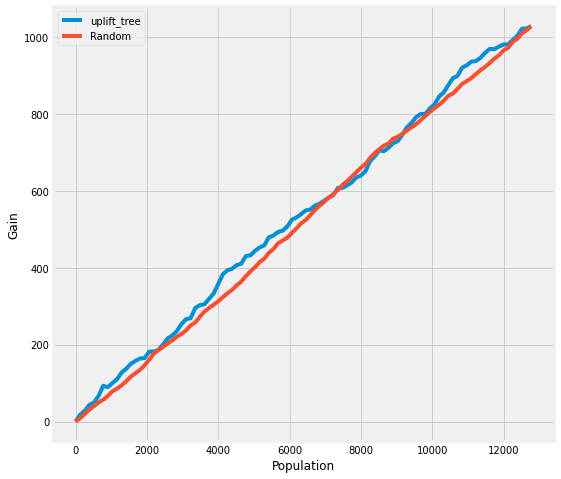

In [48]:
plot_gain(auuc_metrics, outcome_col='visit', treatment_col='is_treated')

In [0]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from IPython.display import Image

In [50]:
df_train.shape

(44800, 20)

In [51]:
# 

# Train uplift tree
uplift_model_V = UpliftTreeClassifier(max_depth = 3, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='Control')

uplift_model_V.fit(df_train[x_names].values,
                 treatment=df_train['Treatment'].values,
                 y=df_train['visit'].values)

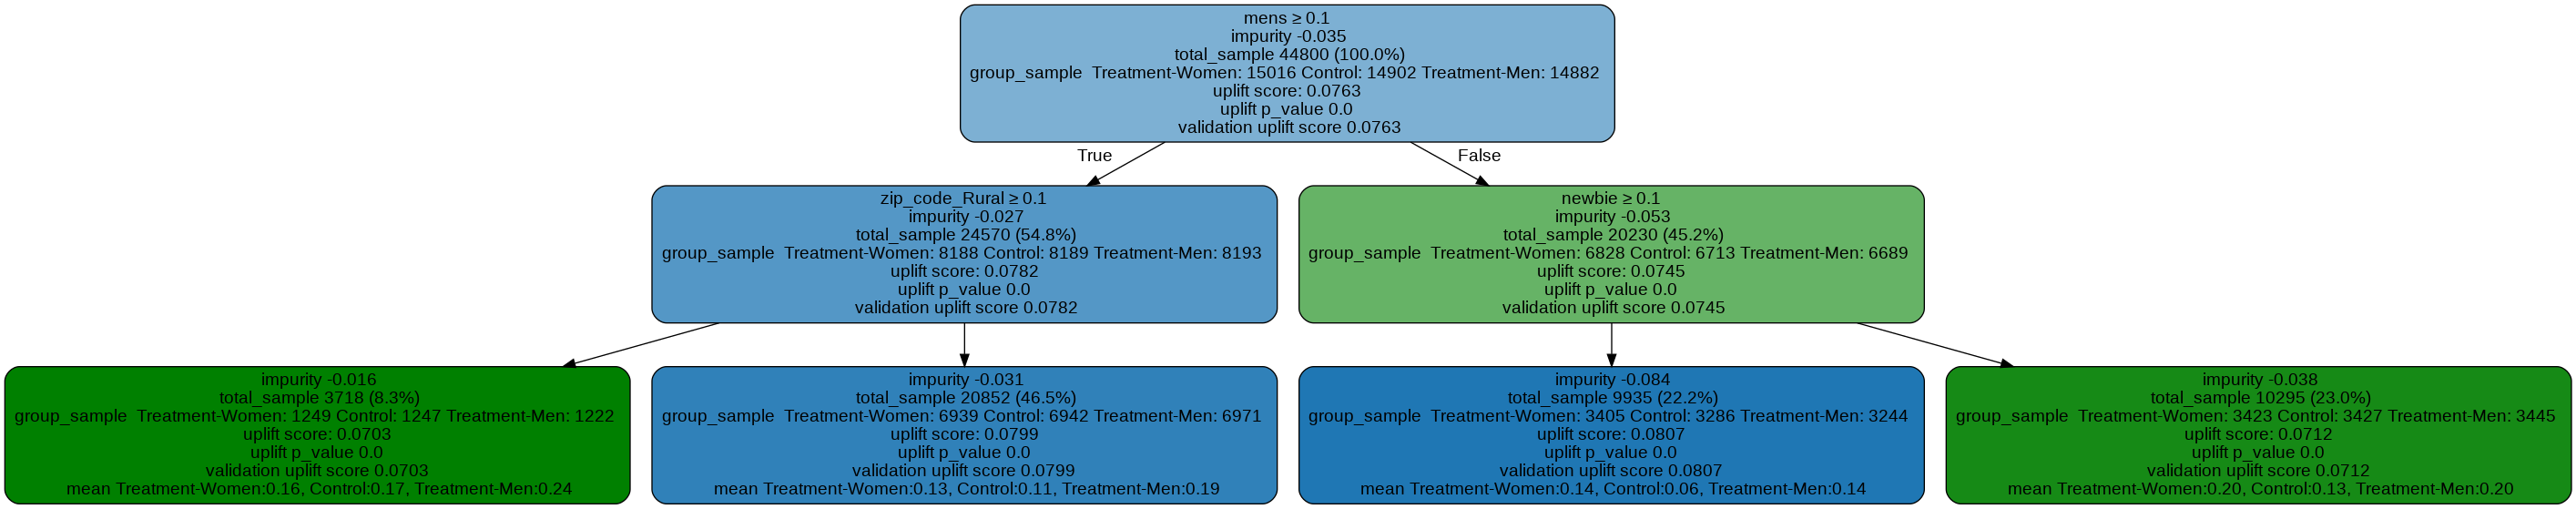

In [52]:
graph = uplift_tree_plot(uplift_model_V.fitted_uplift_tree,x_names)
Image(graph.create_png())